In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [179]:
df = pd.read_csv('data.csv')

In [180]:
df.head()

,UUID,Major,Minor,RSSI,X,Y,Timestamp,SessId
0,b9407f30f5f8466eaff925556b57fe6d,1,-119,-75,3.596879,1.599374,1492950599664,8
1,b9407f30f5f8466eaff925556b57fe6d,1,-111,-75,3.537466,1.600123,1492950599726,8
2,b9407f30f5f8466eaff925556b57fe6d,1,-109,-77,3.521176,1.600329,1492950599743,8
3,b9407f30f5f8466eaff925556b57fe6d,1,-119,-81,3.396601,1.601900,1492950599873,8
4,b9407f30f5f8466eaff925556b57fe6d,1,-111,-79,3.341980,1.602590,1492950599930,8


In [181]:
df = df[df.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

In [182]:
sess = df[df.SessId == 1]

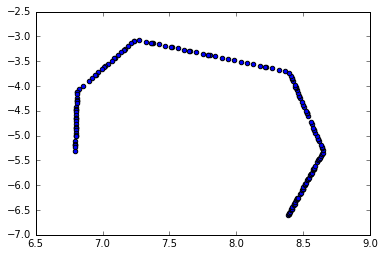

In [197]:
plt.scatter(sess.X, -sess.Y)

In [228]:
def plot_rssi_data(df, figsize=(15, 10), smooth_func=lambda x: x):
    min_time = df.Timestamp.min()
    unique_minors = df.Minor.unique()
    fig = plt.figure(figsize=figsize)
    for i, minor in enumerate(unique_minors):
        bd = smooth_func(df[df.Minor == minor])
        ax = plt.subplot(int(np.ceil(len(unique_minors) / 3)), 3, 1 + i)
        ax.set_title(str(minor))
        plt.plot(bd.Timestamp-min_time, bd.RSSI)
    
    fig = plt.figure(figsize=figsize)
    for i, minor in enumerate(unique_minors):
        bd = smooth_func(df[df.Minor == minor])
        ax = plt.subplot(int(np.ceil(len(unique_minors) / 3)), 3, 1 + i)
        ax.set_title(str(minor))
        plt.scatter(bd.X, -bd.Y, c=-bd.RSSI, cmap='Reds')

In [229]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import medfilt

In [230]:
def rssi_lowess_smooth(df):
    smoothed = lowess(df.RSSI, df.Timestamp)
    new_df = df.copy()
    new_df.RSSI = smoothed[:, 1]
    new_df.Timestamp = smoothed[:, 0]
    return new_df

In [231]:
def create_rssi_median_filter(kernel=9):
    def median_filter(df):
        smoothed = medfilt(df.RSSI, kernel)
        new_df = df.copy()
        new_df.RSSI = smoothed
        return new_df
    return median_filter

In [232]:
def plot_session(df):
    plt.title("Route")
    plt.scatter(df.X, -df.Y)
    plot_rssi_data(sess, smooth_func=rssi_lowess_smooth)    

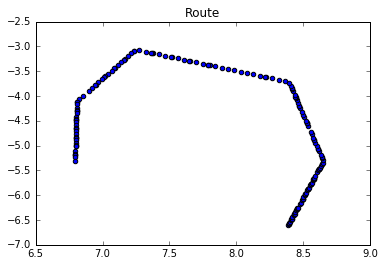

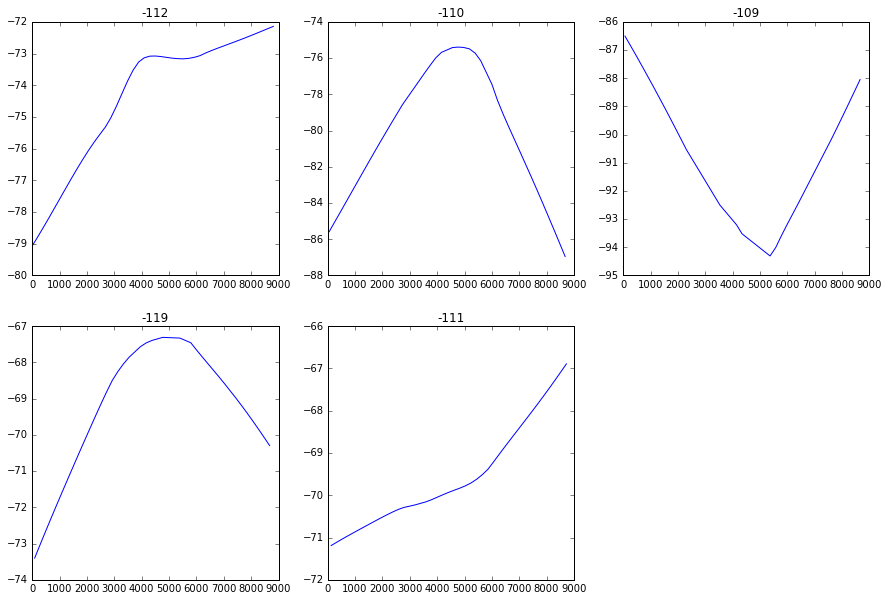

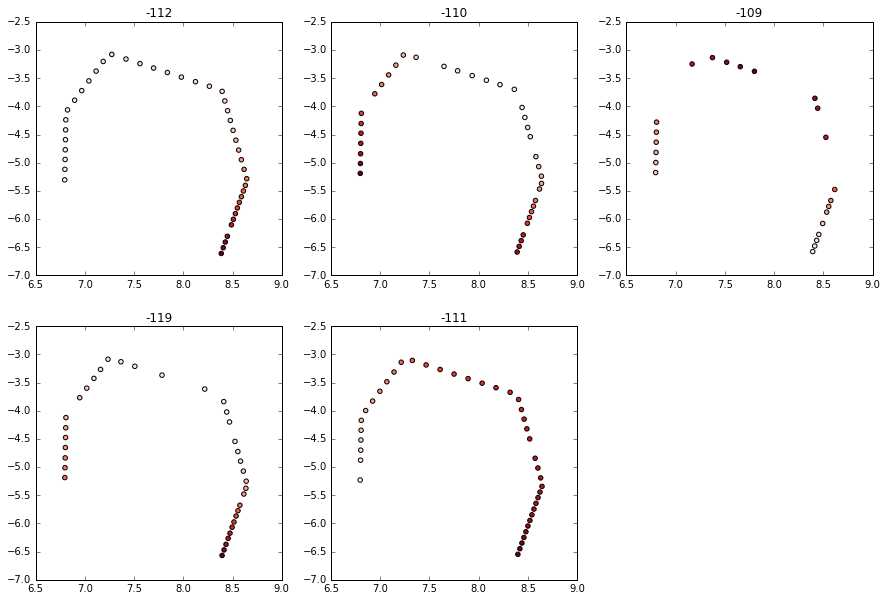

In [233]:
plot_session(sess)